In [1]:
from fastTSNE import TSNE, TSNEEmbedding
from fastTSNE.callbacks import ErrorLogger
from fastTSNE.affinity import PerplexityBasedNN, MultiscaleMixture
from fastTSNE import initialization

from examples import utils

import numpy as np
import scipy.sparse as sp
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import gzip
import pickle

with gzip.open("data/10x_mouse.pkl.gz", "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"]

In [3]:
print('Data set contains %d samples with %d features' % x.shape)

Data set contains 1306127 samples with 50 features


In [4]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38])

In [5]:
colors = dict(enumerate(
    ["#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
     "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
     "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
     "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
     "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
     "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
     "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
     "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
     "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
     "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
     "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
     "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
     "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
     "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800",
     "#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51",
     "#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58"]
))

In [6]:
def plot(x, y, ax=None, draw_centers=True, colors=None, **kwargs) -> None:
    if ax is None:
        import matplotlib.pyplot as plt
        _, ax = plt.subplots()
    
    point_colors = list(map(colors.get, y))
    ax.scatter(x[:, 0], x[:, 1], s=1, alpha=kwargs.get("alpha", 0.1), c=point_colors, rasterized=True)
    
    if draw_centers:
        cluster_labels = np.unique(y)
        cluster_centers = []
        for cluster_id in cluster_labels:
            cluster_centers.append(np.median(x[y == cluster_id], axis=0))
        cluster_centers = np.vstack(cluster_centers)
        
        cluster_center_colors = list(map(colors.get, cluster_labels))
        ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, color=cluster_center_colors, edgecolors="k")
    
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis("off")

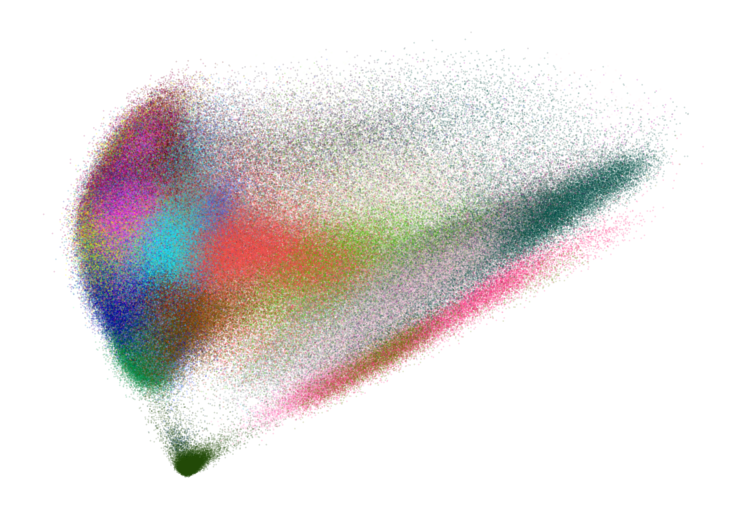

In [7]:
plot(x[:, :2], y, ax=plt.figure(figsize=(13, 9)).gca(), colors=colors, draw_centers=False)

In [8]:
indices = np.random.RandomState(42).permutation(list(range(x.shape[0])))
reverse = np.argsort(indices)

x_sample, y_sample = x[indices[:25000]], y[indices[:25000]]
x_rest, y_rest = x[indices[25000:]], y[indices[25000:]]

In [9]:
%time init = initialization.pca(x_sample)

CPU times: user 2.15 s, sys: 12 ms, total: 2.16 s
Wall time: 97.3 ms


In [10]:
%time affinities = PerplexityBasedNN(x_sample, perplexity=500, method='approx', n_jobs=8)

CPU times: user 7min 51s, sys: 5.75 s, total: 7min 57s
Wall time: 1min 42s


In [11]:
sample_embedding = TSNEEmbedding(
    init, affinities, negative_gradient_method='fft',
    learning_rate=1000, n_jobs=8, callbacks=ErrorLogger(),
)

In [12]:
%time sample_embedding1 = sample_embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5)

Iteration   50, KL divergence  3.1460, 50 iterations in 5.9828 sec
Iteration  100, KL divergence  3.1295, 50 iterations in 7.8589 sec
Iteration  150, KL divergence  3.1281, 50 iterations in 8.7177 sec
Iteration  200, KL divergence  3.1278, 50 iterations in 8.6387 sec
Iteration  250, KL divergence  3.1278, 50 iterations in 8.8106 sec
CPU times: user 15min 7s, sys: 35.6 s, total: 15min 43s
Wall time: 40.5 s


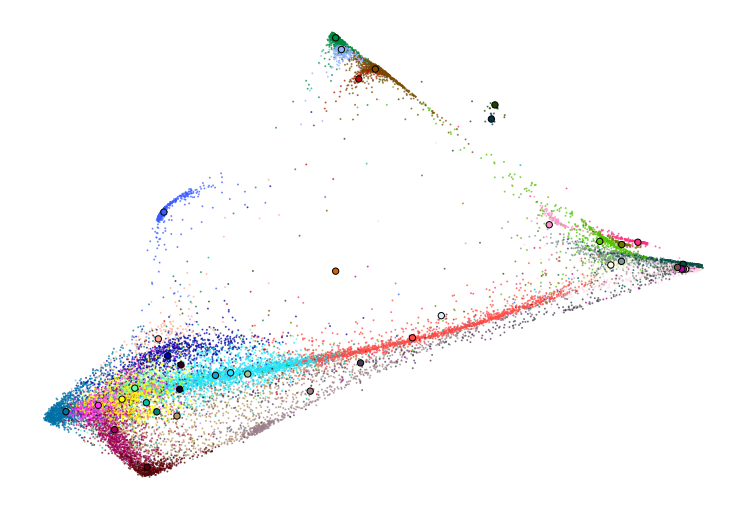

In [13]:
plot(sample_embedding1, y_sample, ax=plt.figure(figsize=(13, 9)).gca(), colors=colors, alpha=0.6)

In [14]:
%time sample_embedding2 = sample_embedding1.optimize(n_iter=750, exaggeration=1, momentum=0.8)

Iteration   50, KL divergence  1.4860, 50 iterations in 8.7721 sec
Iteration  100, KL divergence  1.3559, 50 iterations in 8.6042 sec
Iteration  150, KL divergence  1.3180, 50 iterations in 9.3693 sec
Iteration  200, KL divergence  1.3027, 50 iterations in 9.5379 sec
Iteration  250, KL divergence  1.2951, 50 iterations in 9.6669 sec
Iteration  300, KL divergence  1.2905, 50 iterations in 10.2134 sec
Iteration  350, KL divergence  1.2872, 50 iterations in 10.2679 sec
Iteration  400, KL divergence  1.2844, 50 iterations in 9.4680 sec
Iteration  450, KL divergence  1.2821, 50 iterations in 10.1010 sec
Iteration  500, KL divergence  1.2806, 50 iterations in 10.6236 sec
Iteration  550, KL divergence  1.2785, 50 iterations in 10.2012 sec
Iteration  600, KL divergence  1.2773, 50 iterations in 10.7620 sec
Iteration  650, KL divergence  1.2765, 50 iterations in 10.4341 sec
Iteration  700, KL divergence  1.2754, 50 iterations in 11.2332 sec
Iteration  750, KL divergence  1.2753, 50 iterations i

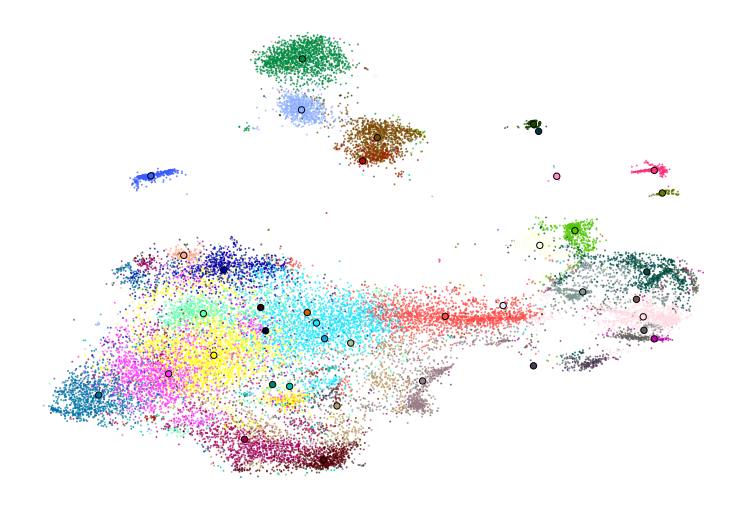

In [15]:
plot(sample_embedding2, y_sample, ax=plt.figure(figsize=(13, 9)).gca(), colors=colors, alpha=0.6)

In [16]:
%time rest_init = sample_embedding2.prepare_partial(x_rest, perplexity=1)

CPU times: user 1min 40s, sys: 976 ms, total: 1min 41s
Wall time: 50.1 s


In [17]:
x_full = np.vstack((x_sample, x_rest))
y_full = np.hstack((y_sample, y_rest))
init_full = np.vstack((sample_embedding1, rest_init))

In [18]:
x_full = x_full[reverse]
y_full = y_full[reverse]
init_full = init_full[reverse]

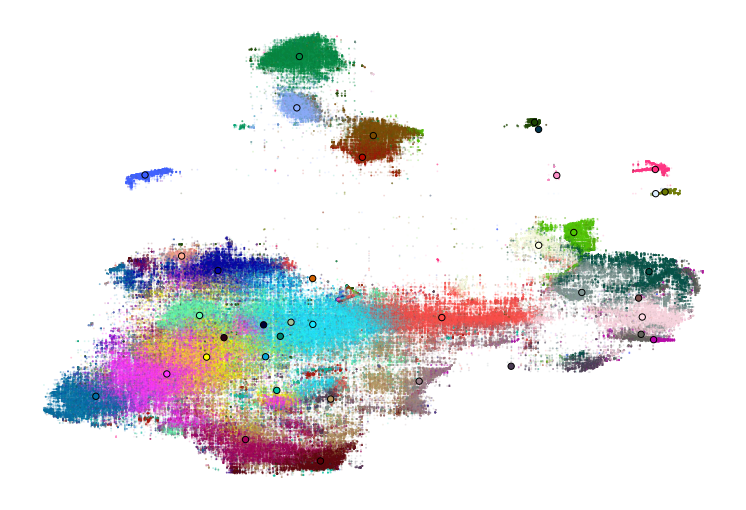

In [19]:
plot(init_full, y_full, ax=plt.figure(figsize=(13, 9)).gca(), colors=colors)

In [20]:
init_full = init_full / (np.std(init_full[:, 0]) * 10000)
np.std(init_full, axis=0)

array([1.00000000e-04, 1.19853153e-04])

In [21]:
%time full_affinities = PerplexityBasedNN(x_full, perplexity=30, method='approx', n_jobs=8)

CPU times: user 50min 7s, sys: 53.4 s, total: 51min
Wall time: 22min 15s


In [22]:
embedding = TSNEEmbedding(
    init_full, full_affinities, negative_gradient_method='fft',
    learning_rate=1000, n_jobs=16, callbacks=ErrorLogger(),
)

In [23]:
%time embedding1 = embedding.optimize(n_iter=500, exaggeration=12, momentum=0.5)

Iteration   50, KL divergence  10.3243, 50 iterations in 34.2596 sec
Iteration  100, KL divergence  10.3204, 50 iterations in 35.7937 sec
Iteration  150, KL divergence  9.4443, 50 iterations in 35.4097 sec
Iteration  200, KL divergence  8.9205, 50 iterations in 34.8768 sec
Iteration  250, KL divergence  8.7344, 50 iterations in 33.2251 sec
Iteration  300, KL divergence  8.6472, 50 iterations in 33.5765 sec
Iteration  350, KL divergence  8.5972, 50 iterations in 33.0666 sec
Iteration  400, KL divergence  8.5778, 50 iterations in 32.8030 sec
Iteration  450, KL divergence  8.5526, 50 iterations in 33.3313 sec
Iteration  500, KL divergence  8.5270, 50 iterations in 33.3395 sec
CPU times: user 1h 41min 9s, sys: 3min 23s, total: 1h 44min 33s
Wall time: 5min 41s


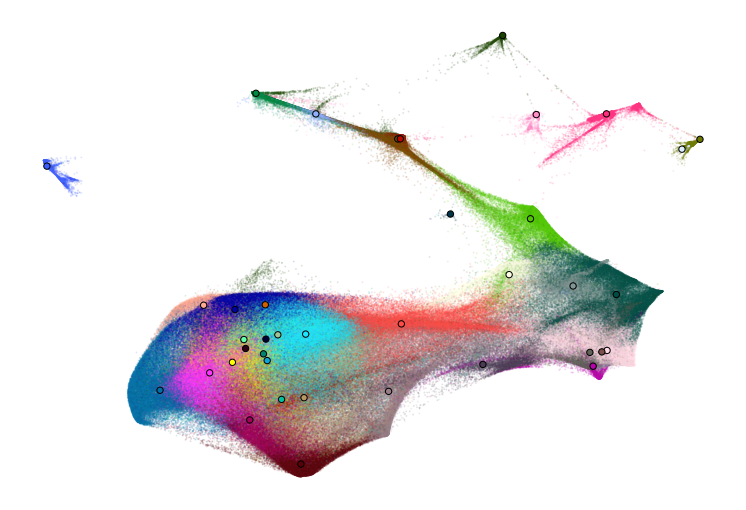

In [24]:
plot(embedding1, y_full, ax=plt.figure(figsize=(13, 9)).gca(), colors=colors)

In [25]:
%time embedding2 = embedding1.optimize(n_iter=250, exaggeration=4, momentum=0.8)

Iteration   50, KL divergence  7.9071, 50 iterations in 36.5849 sec
Iteration  100, KL divergence  7.7457, 50 iterations in 35.0901 sec
Iteration  150, KL divergence  7.6516, 50 iterations in 35.8091 sec
Iteration  200, KL divergence  7.5909, 50 iterations in 35.5856 sec
Iteration  250, KL divergence  7.5484, 50 iterations in 34.6935 sec
CPU times: user 52min 4s, sys: 1min 50s, total: 53min 54s
Wall time: 2min 59s


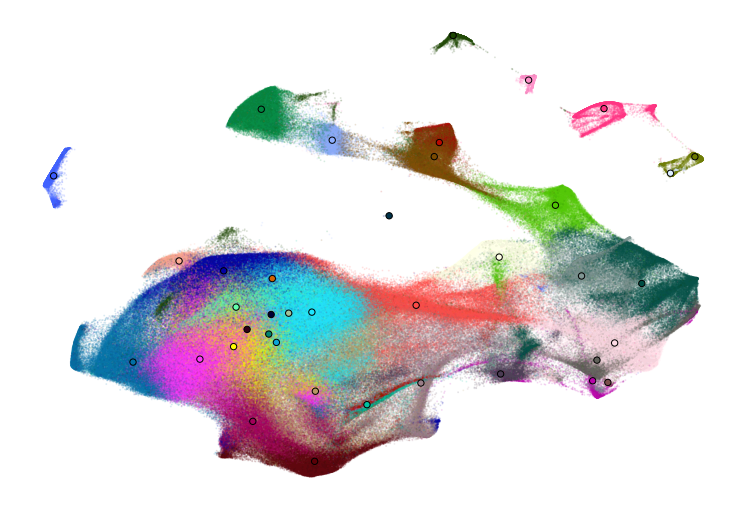

In [26]:
plot(embedding2, y_full, ax=plt.figure(figsize=(13, 9)).gca(), colors=colors)

In [27]:
%time embedding3 = embedding2.optimize(n_iter=250, exaggeration=4, momentum=0.8)

Iteration   50, KL divergence  7.5203, 50 iterations in 34.8678 sec
Iteration  100, KL divergence  7.4970, 50 iterations in 34.9532 sec
Iteration  150, KL divergence  7.4807, 50 iterations in 36.1071 sec
Iteration  200, KL divergence  7.4675, 50 iterations in 36.6856 sec
Iteration  250, KL divergence  7.4570, 50 iterations in 35.7839 sec
CPU times: user 52min 6s, sys: 1min 47s, total: 53min 54s
Wall time: 3min


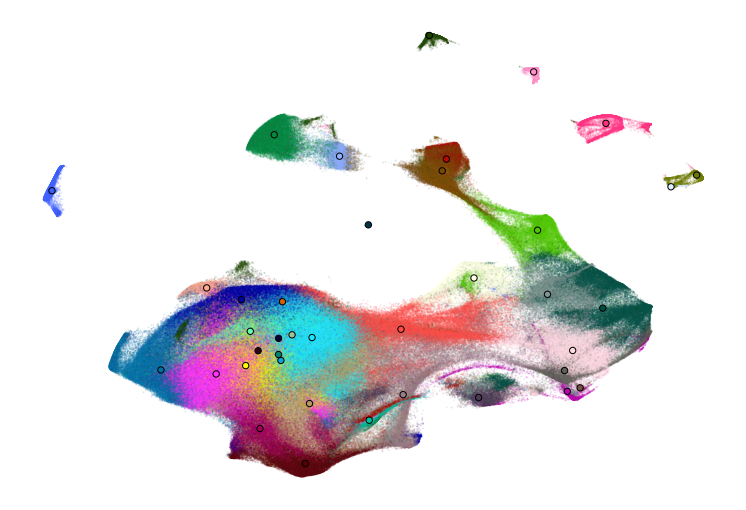

In [28]:
plot(embedding3, y_full, ax=plt.figure(figsize=(13, 9)).gca(), colors=colors)

In [29]:
%time embedding4 = embedding3.optimize(n_iter=250, exaggeration=4, momentum=0.8)

Iteration   50, KL divergence  7.4511, 50 iterations in 37.5106 sec
Iteration  100, KL divergence  7.4440, 50 iterations in 37.1807 sec
Iteration  150, KL divergence  7.4394, 50 iterations in 36.9271 sec
Iteration  200, KL divergence  7.4358, 50 iterations in 37.3976 sec
Iteration  250, KL divergence  7.4318, 50 iterations in 35.3037 sec
CPU times: user 53min 44s, sys: 1min 48s, total: 55min 32s
Wall time: 3min 5s


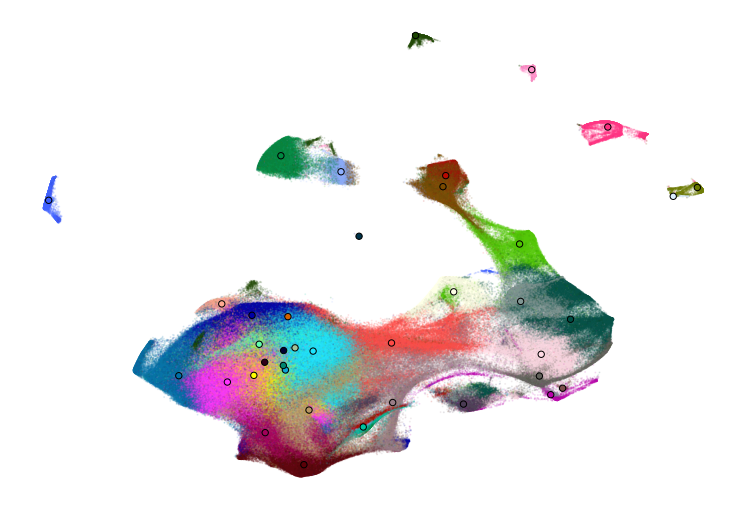

In [30]:
plot(embedding4, y_full, ax=plt.figure(figsize=(13, 9)).gca(), colors=colors)

In [31]:
%time embedding5 = embedding4.optimize(n_iter=250, exaggeration=4, momentum=0.8)

Iteration   50, KL divergence  7.4289, 50 iterations in 36.1222 sec
Iteration  100, KL divergence  7.4278, 50 iterations in 36.7401 sec
Iteration  150, KL divergence  7.4244, 50 iterations in 35.4145 sec
Iteration  200, KL divergence  7.4232, 50 iterations in 35.5049 sec
Iteration  250, KL divergence  7.4216, 50 iterations in 35.8281 sec
CPU times: user 52min 4s, sys: 1min 49s, total: 53min 54s
Wall time: 3min 1s


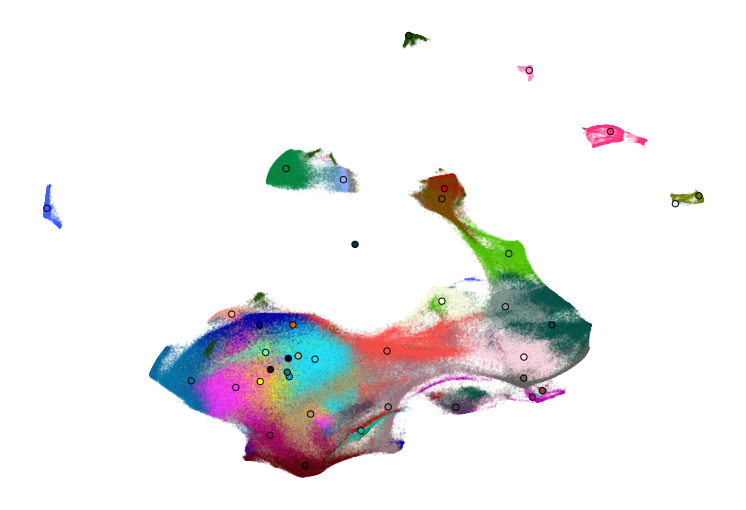

In [32]:
plot(embedding5, y_full, ax=plt.figure(figsize=(13, 9)).gca(), colors=colors)